In [1]:
import numpy as np
import csv
from collections import defaultdict, Counter
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.optimize import nnls

### Dataset preparation

In [2]:
# reading from raw input files to get movie name, id and genres
movies = defaultdict(dict)
all_genres = set()
movies_genre_df_list = []
with open('../Dataset_MovieSummaries/movie.metadata.tsv', encoding='utf-8') as f:
    movie_metadata = csv.reader(f, delimiter='\t')

    # Extracting genres from the metadata
    for line in movie_metadata:
        values = json.loads(line[8]).values()
        genres = list(values)
        all_genres.update(values)
        movies_genre_df_list.append([int(line[0]), line[2], tuple(genres)])


In [3]:
movies_genre = pd.DataFrame(movies_genre_df_list, columns = ['movie_id', 'movie_name', 'genres'])
movies_genre

,movie_id,movie_name,genres
0,975900,Ghosts of Mars,"(Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"(Mystery, Biographical film, Drama, Crime Drama)"
2,28463795,Brun bitter,"(Crime Fiction, Drama)"
3,9363483,White Of The Eye,"(Thriller, Erotic thriller, Psychological thri..."
4,261236,A Woman in Flames,"(Drama,)"
...,...,...,...
81736,35228177,Mermaids: The Body Found,"(Drama,)"
81737,34980460,Knuckle,"(Biographical film, Drama, Documentary)"
81738,9971909,Another Nice Mess,"(Satire, Comedy)"
81739,913762,The Super Dimension Fortress Macross II: Lover...,"(Science Fiction, Japanese Movies, Adventure, ..."


In [4]:
movie_descriptions = []
with open('../Dataset_MovieSummaries/plot_summaries.txt', encoding='utf-8') as f2:
    movie_description = csv.reader(f2, delimiter='\t')
    
    for line in movie_description:
        
        description = line[1]
        id_ = int(line[0])
        movie_descriptions.append([id_, description])
summary_df = pd.DataFrame(movie_descriptions, columns = ['movie_id', 'summary'])

In [5]:
summary_df

,movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [6]:
movies_genre = pd.merge(movies_genre, summary_df, on='movie_id', how='inner')
movies_genre

,movie_id,movie_name,genres,summary
0,975900,Ghosts of Mars,"(Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,White Of The Eye,"(Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,A Woman in Flames,"(Drama,)","Eva, an upper class housewife, becomes frustra..."
3,18998739,The Sorcerer's Apprentice,"(Family Film, Fantasy, Adventure, World cinema)","Every hundred years, the evil Morgana returns..."
4,6631279,Little city,"(Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
...,...,...,...,...
42199,23851782,The Ghost Train,"(Crime Fiction, Thriller, Comedy, Supernatural)",{{plot}} The film opens with a Great Western e...
42200,35228177,Mermaids: The Body Found,"(Drama,)",Two former National Oceanic Atmospheric Admini...
42201,34980460,Knuckle,"(Biographical film, Drama, Documentary)",{{No plot}} This film follows 12 years in the ...
42202,913762,The Super Dimension Fortress Macross II: Lover...,"(Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


In [7]:
# remove genres that occur less than 2500 times
genre_counts = Counter(list(item for sublist in movies_genre['genres'] for item in sublist))
genres_to_remove = [genre for genre, count in genre_counts.items() if count < 2500]
genres_to_remove.extend(['Black-and-white', 'Indie','World cinema','Action/Adventure','Drama','Romantic drama','Short Film', 'Family Film','Adventure'])
def remove_sparse_genres(genre_list):
    return tuple([genre for genre in genre_list if genre not in  genres_to_remove])
movies_genre['genres'] = movies_genre['genres'].apply(remove_sparse_genres)
genres_labels = list(set(item for sublist in movies_genre['genres'] for item in sublist))

In [8]:
mlb = MultiLabelBinarizer()
genres_binary = mlb.fit_transform(movies_genre['genres'])
genres_binary_df = pd.DataFrame(genres_binary, columns=mlb.classes_)
movies_genres_df = pd.concat([movies_genre[['movie_id', 'movie_name','summary']], genres_binary_df], axis=1)

In [9]:
movies_genres_df

,movie_id,movie_name,summary,Action,Comedy,Crime Fiction,Horror,Romance Film,Thriller
0,975900,Ghosts of Mars,"Set in the second half of the 22nd century, th...",1,0,0,1,0,1
1,9363483,White Of The Eye,A series of murders of rich young women throug...,0,0,0,0,0,1
2,261236,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0
3,18998739,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...",0,0,0,0,0,0
4,6631279,Little city,"Adam, a San Francisco-based artist who works a...",0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
42199,23851782,The Ghost Train,{{plot}} The film opens with a Great Western e...,0,1,1,0,0,1
42200,35228177,Mermaids: The Body Found,Two former National Oceanic Atmospheric Admini...,0,0,0,0,0,0
42201,34980460,Knuckle,{{No plot}} This film follows 12 years in the ...,0,0,0,0,0,0
42202,913762,The Super Dimension Fortress Macross II: Lover...,"The story takes place in the year 2092,The Sup...",0,0,0,0,0,0


<Axes: >

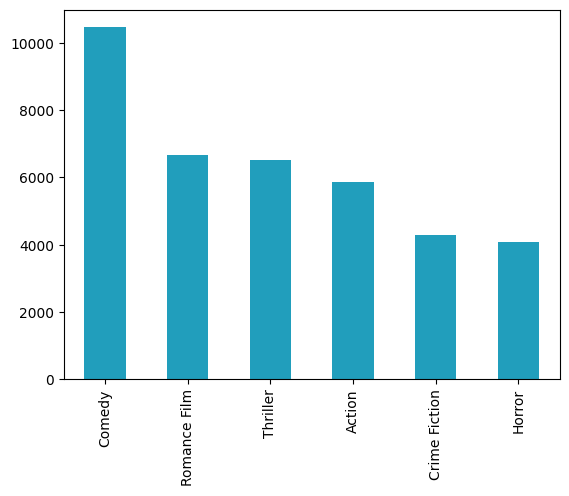

In [10]:
df_labels = movies_genres_df[genres_labels]
label_counts = genres_binary_df.sum().to_dict()
df_labels[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar(color='#219ebc')

In [11]:
# correlation plot for labels
corr = df_labels.corr()
corr.style.background_gradient(cmap='coolwarm')

,Crime Fiction,Action,Comedy,Horror,Thriller,Romance Film
Crime Fiction,1.000000,0.174685,-0.050052,-0.054860,0.302398,-0.059482
Action,0.174685,1.000000,-0.056029,-0.047163,0.238240,-0.082219
Comedy,-0.050052,-0.056029,1.000000,-0.101235,-0.156797,0.126791
Horror,-0.054860,-0.047163,-0.101235,1.000000,0.162129,-0.123257
Thriller,0.302398,0.238240,-0.156797,0.162129,1.000000,-0.103014
Romance Film,-0.059482,-0.082219,0.126791,-0.123257,-0.103014,1.000000


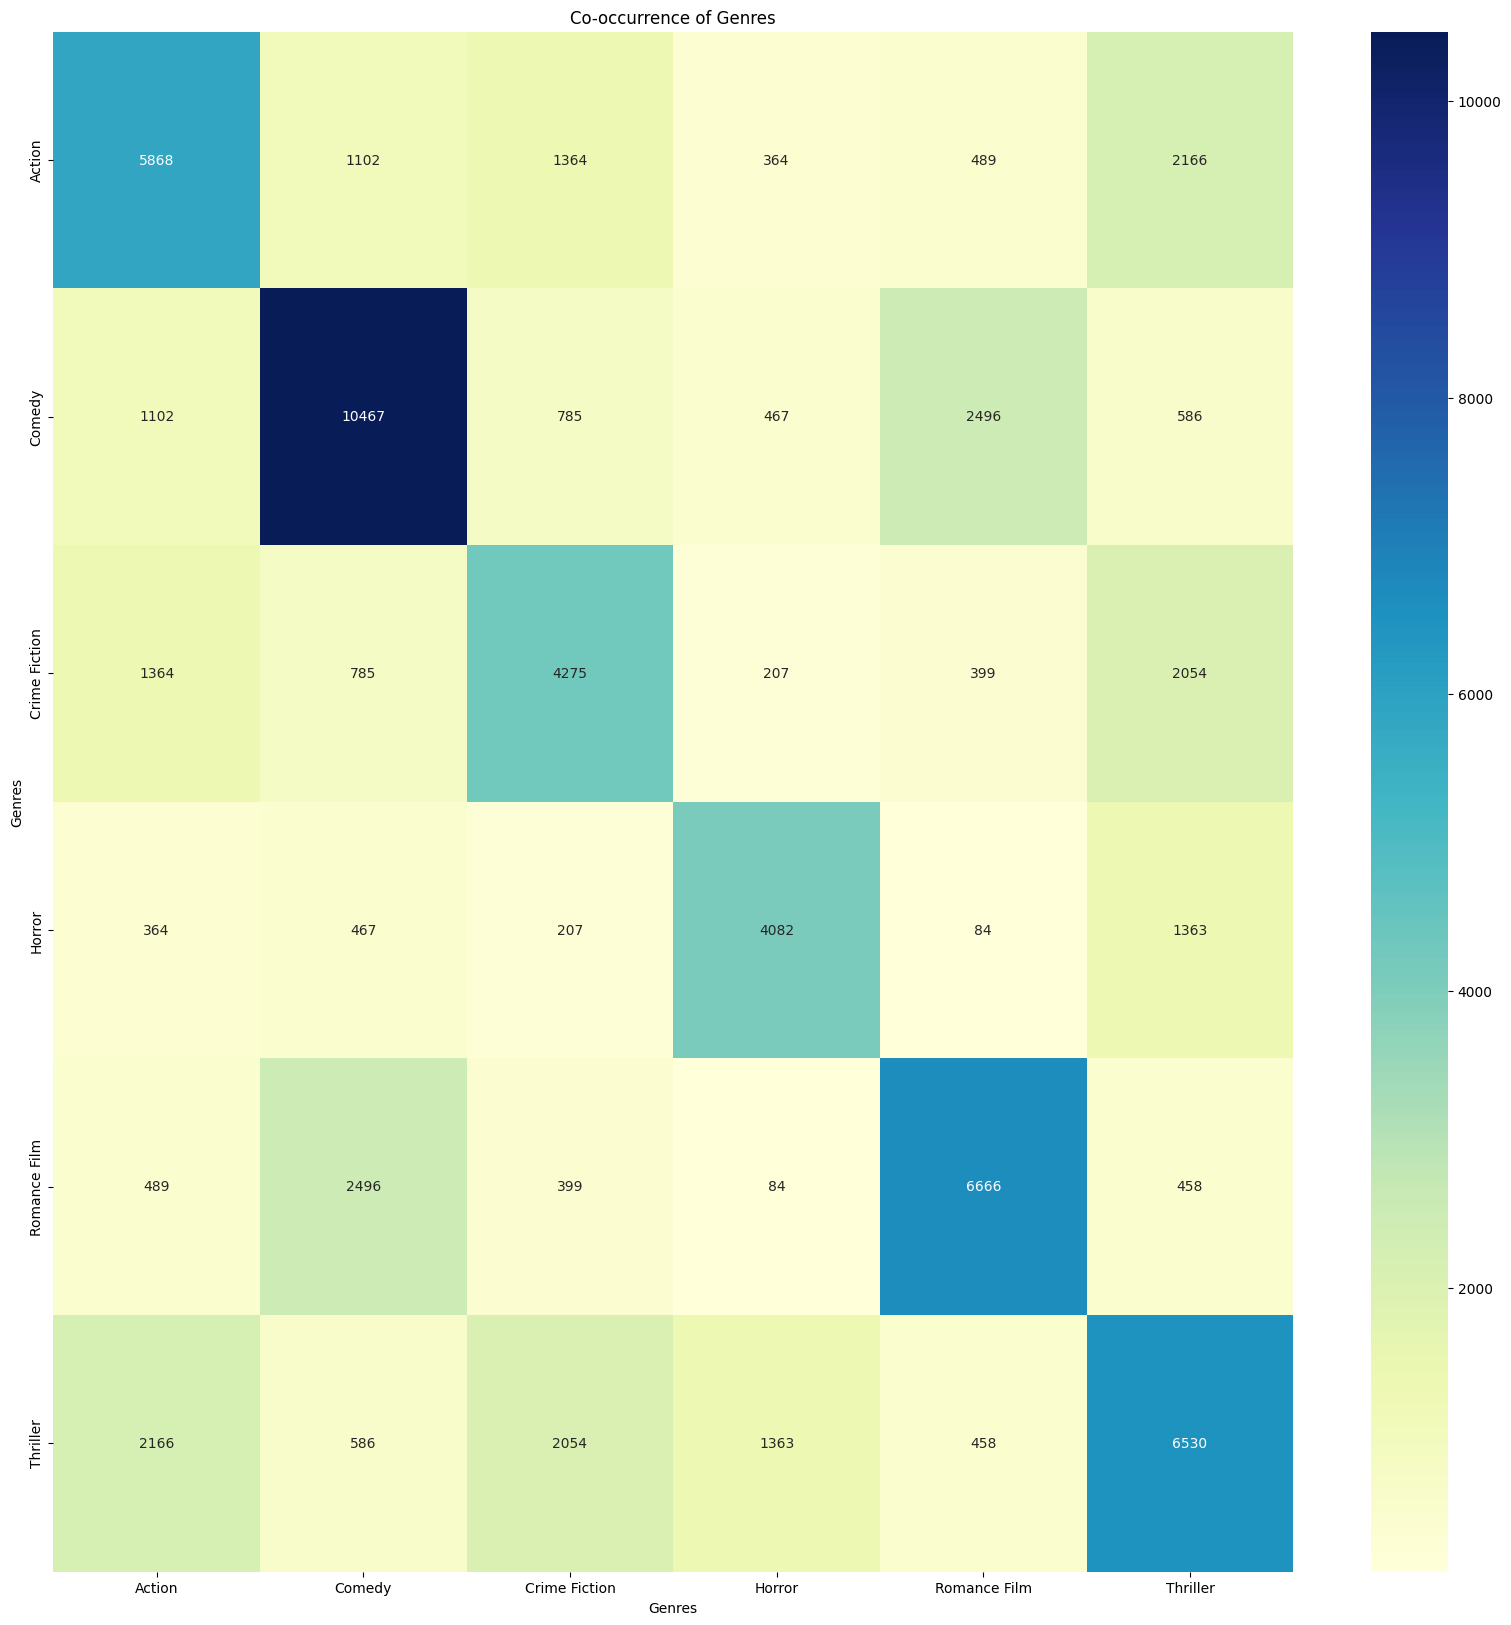

In [12]:
co_occurrence_matrix = genres_binary_df.T.dot(genres_binary_df)
plt.figure(figsize=(20, 20))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Co-occurrence of Genres')
plt.xlabel('Genres')
plt.ylabel('Genres')
plt.show()


In [13]:
# conditional probability matrix
def build_conditional_prob_matrix(df, labels):
    cooc = df[labels].values.T.dot(df[labels].values)
    cooc_norm = cooc.copy().astype(np.float32)
    for i in range(cooc_norm.shape[0]):
        cooc_norm[:, i] /= cooc[i, i]
    return cooc_norm

cooc_norm = build_conditional_prob_matrix(movies_genres_df, genres_labels)
cooc_df = pd.DataFrame(cooc_norm, columns = genres_labels, index = genres_labels)
cooc_df.style.background_gradient(cmap = 'coolwarm')

,Crime Fiction,Action,Comedy,Horror,Thriller,Romance Film
Crime Fiction,1.000000,0.232447,0.074998,0.050710,0.314548,0.059856
Action,0.319064,1.000000,0.105283,0.089172,0.331700,0.073357
Comedy,0.183626,0.187798,1.000000,0.114405,0.089740,0.374437
Horror,0.048421,0.062031,0.044616,1.000000,0.208729,0.012601
Thriller,0.480468,0.369121,0.055985,0.333905,1.000000,0.068707
Romance Film,0.093333,0.083333,0.238464,0.020578,0.070138,1.000000


In [14]:
TARGET_SAMPLES = 5000
target_counts = [TARGET_SAMPLES for _ in genres_labels]
optimal_samples, residuals = nnls(cooc_norm, target_counts)
optimal_samples = optimal_samples.round().astype(np.int32)
optimal_samples

array([3634, 2854, 1805, 4445,  349, 3877], dtype=int32)

In [15]:
# using NNLS, sampling the dataset
def fancy_sample(df, labels, target_count, cond_prob):
    target_counts = np.array([target_count for _ in labels])
    optimal_samples, residuals = nnls(cond_prob, target_counts)
    optimal_samples = np.ceil(optimal_samples).astype(np.int32)

    df_subs = []
    for i, label in enumerate(labels):
        sub_df = df[df[label] == 1]
        df_subs.append(sub_df.sample(optimal_samples[i], 
                                     replace = len(sub_df) < optimal_samples[i]))
    sampled_df = pd.concat(df_subs)
    return sampled_df

resampled_df = fancy_sample(movies_genres_df, genres_labels, TARGET_SAMPLES, cooc_norm)
resampled_df_labels = resampled_df[genres_labels]

In [16]:
resampled_df = resampled_df.drop_duplicates()

<Axes: >

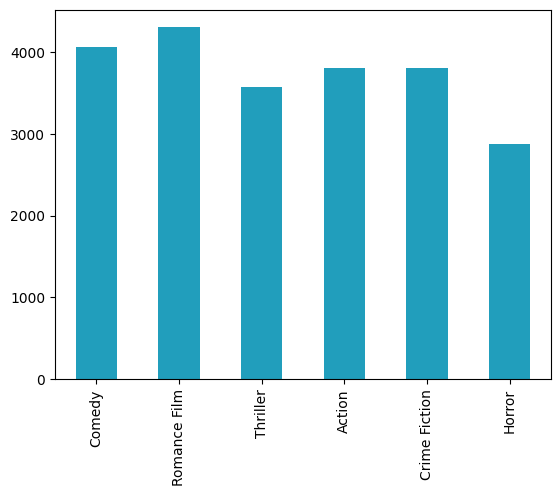

In [17]:
resampled_df[sorted(label_counts.keys(), key = label_counts.get, reverse = True)].sum().plot.bar(color='#219ebc')

In [18]:
resampled_df

,movie_id,movie_name,summary,Action,Comedy,Crime Fiction,Horror,Romance Film,Thriller
28206,23991052,Northern Lights,Homicide detective Nate Burns once lived a to...,0,0,1,0,1,0
10598,2120933,An Innocent Man,James Rainwood is a model citizen. He is happ...,1,0,1,0,0,0
34678,2583417,Street Kings,A disillusioned and borderline psychotic LAPD ...,1,0,1,0,0,1
19627,13237020,Backstreet Dreams,"Dean, a young hood, and his wife take their di...",0,0,1,0,1,0
8011,26655390,Murder at Monte Carlo,A Fleet Street reporter investigates the clai...,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
9795,27713413,Prem Kaa Game,Prem ([[Arbaaz Khan is married to Sheetal an...,0,0,0,0,1,0
29213,33643382,The Rainbowmaker,Datho has been innocent in prison for many ye...,0,0,0,0,1,0
32299,6245744,On Broadway,Emotionally devastated by the death of his unc...,0,0,0,0,1,0
10492,11841923,Sound of the Sea,Ulises arrives in a coastal town near Valencia...,0,0,0,0,1,0


In [19]:
# resampled_df.to_csv('./Dataset_MovieSummaries/balanced_dataset.csv')

In [20]:
# analyse the different genre combinations
# genre_counts_df = movies_genre.groupby('genres').size().reset_index(name='count').sort_values(by='count', ascending=False)
# genre_counts_df
# genre_counts_df[genre_counts_df['count']>500]

In [21]:
def cleaner (summary):
    summary = summary.replace('"','')
    summary = summary.replace("'"," ")
    return summary

resampled_df['summary'] = resampled_df['summary'].apply(cleaner)


In [22]:
resampled_df['summary']

28206    Homicide detective Nate Burns  once lived a to...
10598    James Rainwood  is a model citizen. He is happ...
34678    A disillusioned and borderline psychotic LAPD ...
19627    Dean, a young hood, and his wife take their di...
8011     A Fleet Street reporter  investigates the clai...
                               ...                        
9795     Prem ([[Arbaaz Khan  is married to Sheetal  an...
29213    Datho  has been innocent in prison for many ye...
32299    Emotionally devastated by the death of his unc...
10492    Ulises arrives in a coastal town near Valencia...
70       Priya Amal Raj  loses her mother at a very you...
Name: summary, Length: 13414, dtype: object

In [23]:
resampled_df.to_csv('../Dataset_MovieSummaries/Dataset.csv')

In [24]:
resampled_df.isna().any()

movie_id         False
movie_name       False
summary          False
Action           False
Comedy           False
Crime Fiction    False
Horror           False
Romance Film     False
Thriller         False
dtype: bool